## Todo
figure out time step, spotting random, etc

Do probability of spotting for a given cell, then sample gaussian from its window to get new ign loc

Model evaluation with polygons, area

In [ ]:
"""
it's gotta become a fuel and heat model

each cell has a p_ign that can be combined with veg characteristics to produce a fuel status
each cell will have a heat value
that heat will flow into the cell's water and fuel compartments, adjacent cells, and also out to atmosphere
the cell ignites when the fuel heat reaches some level determined by fuel/atmo characteristics
when ignited, fuel becomes heat at a rate determined by heat and fuel/atmo characteristics
heat flows out of the cell at a rate determined by heat and atmo characteristics
from the heat that leaves the cell, each neighboring cell takes in some of that heat, determined by wind and topography


so for example: first the cell has to get hot enough to ignite. this may involve boiling off some water first so
water status influences a sort of 'heat buffer' that has to be overcome first. then, the fuel itself has to get
sufficiently hot to ignite. with a heat/wind to height function we can even capture understory/crown behaviour.
once ignited, the fuel in the cell will burn and become more heat at a rate that depends on atmospheric conditions,
fuel type, and how hot it already is. then, heat flows out of a cell at a rate determined by how much heat is in the
cell and how windy it is. that heat flows into neighboring cells at rates determined by wind and topography. some of
the heat just escapes the system (goes up into the atmosphere)


to implement this, things i need:
fuel heat stored from veg mtx
fuel burn rate from veg mtx
fuel ignition heat from veg mtx
(!!!) water stored in soil and canopy (the canopy of grass is the floor)

"""

### possible efficiency improvements

When spreading, calculate when a cell will become relevant, only operate on that cell when necessary. Like task scheduling.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation as FA
import rasterio as rio
from matplotlib import colors
from itertools import chain
import multiprocessing as mp
import collections
import datetime
import re

In [2]:
path_to_data = '/home/adam.viray/Documents/CA/data/test_fires/MT4703711487920170717/240m/'

In [3]:
RoS_cube = np.power(10,rio.open(path_to_data+'RoS.tif').read())*4046/24
wfrom = rio.open(path_to_data+'wdir.tif').read()
wspd = rio.open(path_to_data+'wspd.tif').read()
slope = rio.open(path_to_data+'slope.tif').read()
aspect = rio.open(path_to_data+'aspect.tif').read()

In [4]:
upslope = ((270 - aspect)*np.pi/180 + np.pi) % (2*np.pi) - np.pi

wfrom[wfrom<0] = np.nan
wdir = ((270 - wfrom)*np.pi/180 + np.pi) % (2*np.pi) - np.pi
wspd[wspd<0] = 0

# maximum rate and direction of spread
# some bullshit i made up, just graph it
# based off some article i read about the 10% rule
wm = (wspd*3.6) # m s-1 -> km hr-1
wm = np.exp(0.05*wm)/(1+np.exp(0.6*(10-wm)))
# slope from Butler, Anderson, Catchpole 2007
sm = 0.001*np.exp(0.38*slope) + 1.6
# turn area into length
# area = RoS*4046/62500
# a = (1-np.exp(-2*np.sqrt(3)*np.pi))/2/np.sqrt(3)
# b = 2*np.sqrt(2)*(1-np.exp(-np.sqrt(3)*np.pi))/np.sqrt(3)
# k = 250*(np.sqrt(b**2+4*a*area) - b)/2/a
k = 120*1.732083333553463*(np.sqrt(2.6436051667022675 + 1.1546788547967213*RoS_cube/120**2) - 1.6259167157952057)
r_max_cube = np.sqrt(np.square(wm) + np.square(sm) + 2*wm*sm*np.cos(wdir-upslope))*np.repeat(k,24,axis=0)[:wm.shape[0]]
phi_max_cube = (upslope + np.arctan2(wm*np.sin(wdir-upslope), sm + wm*np.cos(wdir-upslope)))

In [14]:
np.unique(r_max_cube/120)

array([9.2804417e-05, 2.7234614e-04, 3.3983393e-04, ..., 2.4174922e+02,
       2.4249892e+02,           nan], dtype=float32)

(array([1272235., 1125155.,  521008.,  282533.,  175723.,  118023.,
          82485.,   61555.,   45166.,   36428.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

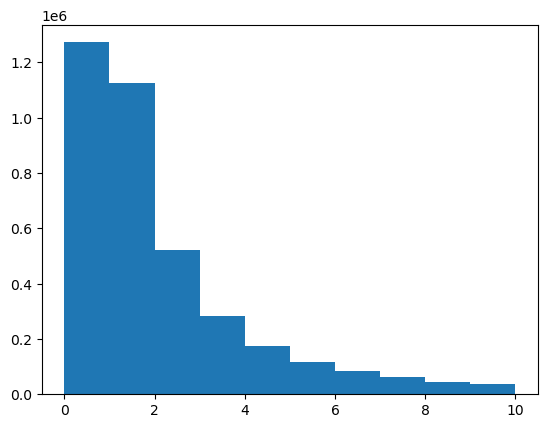

In [20]:
plt.hist((r_max_cube.flatten())/120, range=[0,10])

In [30]:
burnday = rio.open(path_to_data+'burnday.tif').read()[0]

In [16]:
viirs = [np.argwhere(24*burnday<=200*24+hour).T for hour in np.arange(1200)]
viirs[0]

array([[49, 49],
       [11, 12]])

In [15]:
jday = np.min(burnday[~np.isnan(burnday)])
start_time = datetime.datetime(2017, 1, 1) + datetime.timedelta(jday - 1)

In [17]:
str((np.datetime64(start_time,'h')+10+24*1)).replace('T',' ')

'2017-07-20 10'

In [23]:
re.findall('\d{3,}',path_to_data)[0][-8:-4]

'2017'

In [48]:
class fireCA:
    
    def __init__(self, path_to_data=False):
        self.plotting = False
        self.show_plot = False
        self.rng = np.random.default_rng()
        
        # constants
        self.consts = {'spatial_resolution':60,
                       's_base':2**7,
                       'weight':0.325,
                       'weight_d':1.6,
                       'weight_phi':0.7,
                       'spread_threshold':0.925,
                       'burn_speed':0.07,
                       'spot_sigma':0.3,
                       'brand_sigma':0.3,
                       'veg_dens_threshold':0.25,
                       'bare_dirt_threshold':0.1,
                       'ign_loc':[],
                       'fname':'',
                       'start_time':np.datetime64('now','h')-6}
                       
        # if it gets pointed to data, initialize with data
        if path_to_data:
            self.get_data(path_to_data)
            self.preprocess()
    
    def get_data(self, path_to_data):
        # ignition probability dataset
        print('reading prob')
        self.prob_cube = rio.open(path_to_data+'prob.tif').read()
        
        # rate of spread dataset
        self.RoS_cube = rio.open(path_to_data+'RoS.tif').read()

        # topography
        print('reading topo')
        self.slope = rio.open(path_to_data+'slope.tif').read()[0]
        self.aspect = rio.open(path_to_data+'aspect.tif').read()[0]
        self.dem = rio.open(path_to_data+'dem.tif').read()[0]
        self.hillshade = rio.open(path_to_data+'hillshade.tif').read()[0]
        
        # wind
        print('reading wind')
        self.wfrom = rio.open(path_to_data+'wdir.tif').read()
        self.wspd = rio.open(path_to_data+'wspd.tif').read()
        
        # vegetation
        print('reading veg')
        self.veg_mtx = rio.open(path_to_data+'veg.tif').read()/100
        self.noveg_mtx = rio.open(path_to_data+'noveg.tif').read()[0]
        
        # initial state
        self.initial_state = (rio.open(path_to_data+'state.tif').read()[0]).astype(int)

        # burnday
        self.burnday = rio.open(path_to_data+'burnday.tif').read()[0]
    
    def preprocess(self):
        print('preprocessing')
        t,self.m,self.n = self.prob_cube.shape
        self.t = min(self.wfrom.shape[0], t*24)

        self.LEFT = 0# int(3/50*self.n)
        self.RIGHT = self.n# int(1/3*self.n)
        self.TOP = 0# int(1/3*self.m)
        self.BOTTOM = self.m# int(2/3*self.m)

        self.burnday[self.burnday<=205] = np.nan
        burn_day = self.burnday[self.TOP:self.BOTTOM,self.LEFT:self.RIGHT]
        burn_day = burn_day[~np.isnan(burn_day)]
        self.VIIRS_burnt_pixels = np.zeros(self.t)
        for i in range(self.t):
            j = i + 205*24
            self.VIIRS_burnt_pixels[i] = np.sum(burn_day <= (j//24 + (j%24)/24))
        
        self.upslope = ((270 - self.aspect)*np.pi/180 + np.pi) % (2*np.pi) - np.pi
        
        self.wfrom[self.wfrom<0] = np.nan
        self.wdir = ((270 - self.wfrom)*np.pi/180 + np.pi) % (2*np.pi) - np.pi
        self.wspd[self.wspd<0] = 0
        
        # maximum rate and direction of spread
        # some bullshit i made up, just graph it
        wm = (self.wspd*3.6)
        wm = np.exp(0.05*wm)/(1+np.exp(0.6*(10-wm)))
        # slope from Butler, Anderson, Catchpole 2007
        sm = 0.001*np.exp(0.38*self.slope) + 1.6
        # turn area into length
        # area = RoS*4046/62500
        # a = (1-np.exp(-2*np.sqrt(3)*np.pi))/2/np.sqrt(3)
        # b = 2*np.sqrt(2)*(1-np.exp(-np.sqrt(3)*np.pi))/np.sqrt(3)
        # k = 250*(np.sqrt(b**2+4*a*area) - b)/2/a
        k = self.consts['spatial_resolution']*1.732083333553463*(np.sqrt(2.6436051667022675 + 3*1.1546788547967213*(self.RoS_cube/self.consts['spatial_resolution'])**2) - 1.6259167157952057)
        self.r_max_cube = np.sqrt(np.square(wm) + np.square(sm) + 2*wm*sm*np.cos(self.wdir-self.upslope))*np.repeat(k,24,axis=0)[:wm.shape[0]]
        self.phi_max_cube = (self.upslope + np.arctan2(wm*np.sin(self.wdir-self.upslope), sm + wm*np.cos(self.wdir-self.upslope)))
        
        self.fuel_burn_speed = 1.2*self.veg_mtx[0]+0.8*self.veg_mtx[1]

        self.consts['ign_loc'] = set([tuple(x) for x in np.argwhere(self.initial_state==2)])
        
        self.reset()
    
    def reset(self):
        self.burning = set(self.consts['ign_loc'])
        self.smoldering = set()
        self.burnt = set()
        #self.unburnable = set([tuple(x) for x in np.argwhere(self.noveg_mtx)])
        self.unburnable = set([tuple(x) for x in np.argwhere(self.veg_mtx[1]<self.consts['veg_dens_threshold'])])\
                          .union(set([tuple(x) for x in np.argwhere(self.noveg_mtx)]))
        self.ign_dict = collections.defaultdict(float)
        self.burn_dict = collections.defaultdict(float)
        
        self.CA_burnt_pixels = np.empty(self.t-1)
        
        self.phi_max = self.phi_max_cube[0]
        self.r_max = self.r_max_cube[0]
        self.wind_spd = self.wspd[0]
        self.wind_dir = self.wdir[0]
        self.prob = self.prob_cube[0]
    
    
    def plot(self, path=False):
        state_mtx = np.ones_like(self.prob).astype(int)*3
        for pixel in self.smoldering:
            state_mtx[pixel] = 1
        for pixel in self.burning:
            state_mtx[pixel] = 2
        for pixel in self.burnt:
            state_mtx[pixel] = -1
        for pixel in self.unburnable:
            state_mtx[pixel] = 0
        
        #cmap = colors.ListedColormap(['black', 'dimgray', 'red', 'gold', 'darkgreen'])
        cmap = colors.ListedColormap(['black', (0,0,0,0), 'red', 'gold', (0,0,0,0)])
        norm = colors.BoundaryNorm([-1,0,1,2,3,4], cmap.N)
        
        plt.clf()
        plt.imshow(self.hillshade[self.TOP:self.BOTTOM,self.LEFT:self.RIGHT], alpha=1, cmap='gray', interpolation='none', zorder=0)
        plt.imshow(state_mtx[self.TOP:self.BOTTOM,self.LEFT:self.RIGHT], cmap=cmap, alpha=0.6, norm=norm, interpolation='none', zorder=10)
        viirs = np.argwhere(self.burnday[self.TOP:self.BOTTOM,self.LEFT:self.RIGHT]<=self.day+205).T
        plt.scatter(viirs[1], viirs[0], c='r', s=1, alpha=0.6, zorder=5)
        plt.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        plt.title(f"{str((self.consts['start_time']+self.hour+24*self.day)).replace('T',' ')}:00\n"\
                  f"area burned: {((self.consts['spatial_resolution']/1000)**2*(len(self.burning)+len(self.smoldering)+len(self.burnt))):.2f} km2")
        if path:
            plt.savefig(path)
        if self.show_plot:
            plt.show()
    
    def step_size(self, s, max_spread):
        if s < 2:
            return 1
        if max_spread*s/self.consts['s_base'] > self.consts['spatial_resolution']:
            s = self.step_size(s/2, max_spread)
        return int(s)
    
    def get_adj_dw(self, pixel):
        weights = {}
        i,j = pixel
        
        r_max = self.r_max[pixel]#*self.s/self.consts['s_base']
        # this line makes the radius nonlinear on RoS. rough substitution for spotting behaviour.
        #r = (r_max/self.consts['spatial_resolution'] + 1)**(1 + 1/(1+np.exp(-r_max+100)) + 1/(1+np.exp(-r_max+250))) # in units of grid cells
        r = r_max/self.consts['spatial_resolution'] + 1
        phi = self.phi_max[pixel]
        l = int(r)
        if l < 1: l = 0      
        candidates = set([(y,x) for y in range(max(i-1-l, 0),min(i+2+l, self.m)) for x in range(max(j-1-l, 0),min(j+2+l, self.n))]) - set([pixel])
        for neighbor in candidates:
            # theta is the direction from the current pixel to the neighbor
            theta = np.arctan2(pixel[0]-neighbor[0],neighbor[1]-pixel[1])
            diff = np.abs(phi - theta)
            if diff > np.pi:
                diff = 2*np.pi - diff
            d = np.linalg.norm(np.subtract(pixel,neighbor))
            
            # the first condition defines the neighborhood shape
            if (d <= np.sqrt(2)+r*np.exp(-np.sqrt(3)*diff)) and (~np.isnan(self.r_max[neighbor]))\
            and (neighbor not in chain(self.burning,self.smoldering,self.burnt,self.unburnable)):
                # weights are 2-d gaussian in distance and angle, scaled by RoS
                weights[neighbor] = self.r_max[neighbor]/100*self.consts['weight']*np.exp((-(d/((r+1)*self.consts['weight_d']))**2-(diff/(np.pi/2*self.consts['weight_phi']))**2)/2)
        return weights

    def spread(self):
        # progress fire in all burning cells
        # if any burning cells reach the threshold, transition them to smoldering
        # along the way, release firebrands
        remove_from_burning = set()
        for pixel in self.burning:
            k = self.r_max[pixel]/self.consts['spatial_resolution']*self.s/self.consts['s_base']
            area = (-(np.exp(-2*np.sqrt(3)*np.pi)-1)/(2*np.sqrt(3))*k**2 - 2*np.sqrt(2)/(np.sqrt(3))*(np.exp(-np.sqrt(3)*np.pi)-1)*k)
            spread = area*self.consts['burn_speed']#*self.fuel_burn_speed[pixel]
            self.burn_dict[pixel] += spread
            if self.burn_dict[pixel] >= 1:
                remove_from_burning.add(pixel)
                self.smoldering.add(pixel)
            """
            ignited = set()
            # forest fraction times meters spread somehow becomes firebrands released
            n_brands = int(self.veg_mtx[0][pixel]*spread)
            # each firebrand samples from a distribution and that number is the distance it travels
            # the distribution should depend on wind speed and intensity (sub RoS)
            sigma = (self.wind_spd[pixel]*2.24/50*1609/self.consts['spatial_resolution'])*self.consts['spot_sigma']
            reach = np.abs(self.rng.normal(0,sigma,n_brands))
            reach = reach[reach>1]
            phi = self.wind_dir[pixel]
            brands = [(y,x) for x in np.rint(pixel[1]+reach*np.cos(phi)).astype(int) for y in np.rint(pixel[0]-reach*np.sin(phi)).astype(int)]
            branded = set(brands)
            # if the firebrand lands in an ignitable cell, that cell ignites (with a probability?)
            for neighbor in branded:
                if (0 <= neighbor[0] < self.m) and (0 <= neighbor[1] < self.n) and (~np.isnan(self.r_max[neighbor]))\
                and (neighbor not in chain(self.burning,self.smoldering,self.burnt,self.unburnable))\
                and (np.any(self.rng.normal(0,self.consts['brand_sigma'],np.sum([1 for coord in brands if coord == neighbor]))>1-self.prob[neighbor])):
                    ignited.update(neighbor)
            self.burning.update(ignited)
            """
        self.burning.difference_update(remove_from_burning)
    
    def ignite(self):
        spreading = set()
        for pixel in self.burning:
            if self.burn_dict[pixel] >= self.consts['spread_threshold']:
                i,j = pixel
                neighbors = set([(y,x) for y in range(max(i-1, 0),min(i+2, self.m)) for x in range(max(j-1, 0),min(j+2, self.n))]) - set([pixel])
                if len(neighbors.intersection(self.burning)) != len(neighbors):
                    spreading.update([pixel])

        if len(spreading) > 1e20:
            with mp.Pool(int(mp.cpu_count()/2)) as p:
                weight_list = [x.items() for x in p.map(self.get_adj_dw, spreading)]
        else:
            weight_list = [x.items() for x in [self.get_adj_dw(pixel) for pixel in spreading]]
        
        try:
            for neighbor,weight in chain(*weight_list):
                self.ign_dict[neighbor] += weight * self.s/self.consts['s_base']
                if self.ign_dict[neighbor] >= 1-self.prob[neighbor]:
                    del self.ign_dict[neighbor]
                    self.burning.update([neighbor])
        except ValueError:
            pass
    
    def run(self):
        # take t and multiply it by 32 (s_base)
        # keep track of how many 32ths have passed
        # begin a while loop
        # update weather conditions
        # determine step size
        # transition smoldering to burnt
        # progress fire in all burning cells
        # if any burning cells reach the threshold, transition them to smoldering
        # ignite susceptible cells
        # increment 32ths
        
        self.i = 0
        self.hour = 0
        self.day = 0
        while self.i < (self.t-1)*self.consts['s_base']:
            
            # exit condition
            if len(self.burning) > 5000:
                print("Number of burning cells exceeds 500")
                self.plot(self.consts['gif_dir']+f'{self.day:02}_{self.hour+1:02}.png')
                break
            
            # update weather conditions
            if self.i > self.consts['s_base']*(24*self.day+self.hour):
                j = int(self.i//self.consts['s_base'])
                self.CA_burnt_pixels[j] = len(self.burning)+len(self.smoldering)+len(self.burnt)
                if self.hour != j%24:
                    self.hour = j%24
                    self.wind_spd = self.wspd[j]
                    self.wind_dir = self.wdir[j]
                    self.r_max = self.r_max_cube[j]
                    self.phi_max = self.phi_max_cube[j]
                    if self.hour == 0:
                        if self.plotting:
                            self.plot(self.consts['gif_dir']+f'{self.day:02}_{self.hour:02}.png')
                        self.day = int(j//24)
                        self.prob = self.prob_cube[self.day]
                        
            
            # determine step size
            try:
                max_spread = np.max([self.r_max[pixel] for pixel in self.burning])
            except ValueError:
                max_spread = 0
                if len(self.smoldering) == 0:
                    print(f'Fire extinguished.')
                    break
            self.s = self.step_size(self.consts['s_base'], max_spread)
            
            # transition smoldering to burnt
            self.burnt.update(self.smoldering)
            self.smoldering = set()
            
            # progress fire in all burning cells
            self.spread()
            
            # ignite neighboring cells
            self.ignite()

            # heat escapes from cells which are heating up
            self.ign_dict.update((x,y*(1-self.s/self.consts['s_base'])) for x,y in self.ign_dict.items())
            
            # increment 32ths
            self.i += self.s

In [49]:
# modulate weight by RoS: sigmoid
# how to make it not burn itself out? transition from spreading to burnt? scale RoS in burn across cell?

In [50]:
CA = fireCA('/home/adam.viray/Documents/CA/data/riceridge/120m/')

reading prob
reading topo
reading wind
reading veg
preprocessing


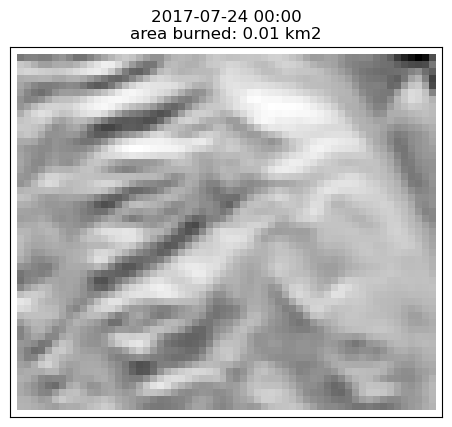

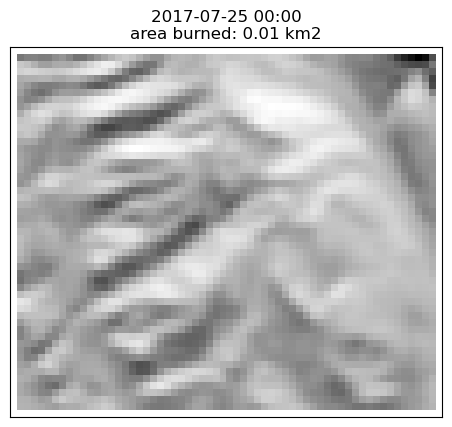

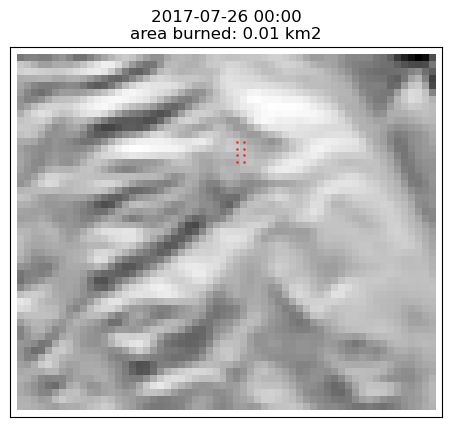

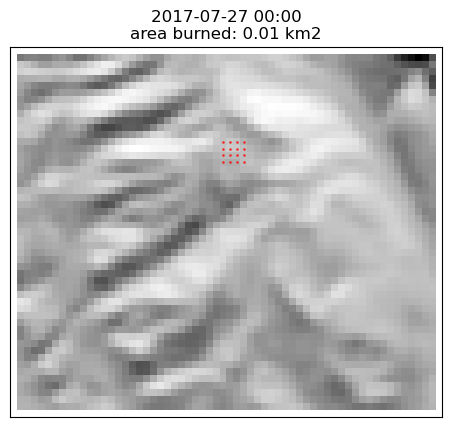

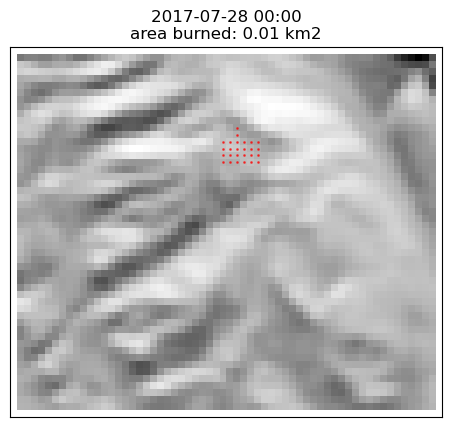

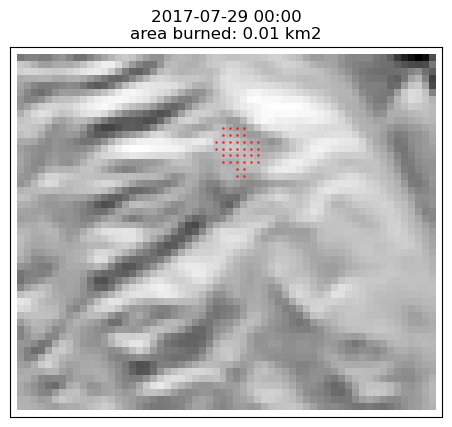

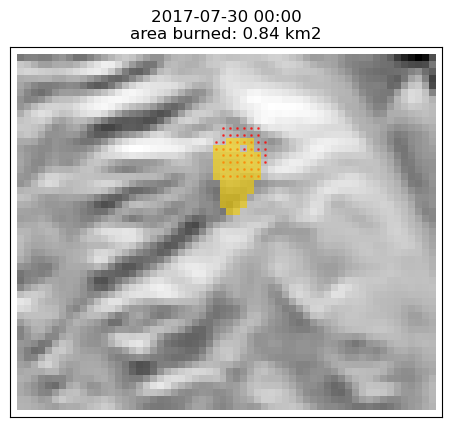

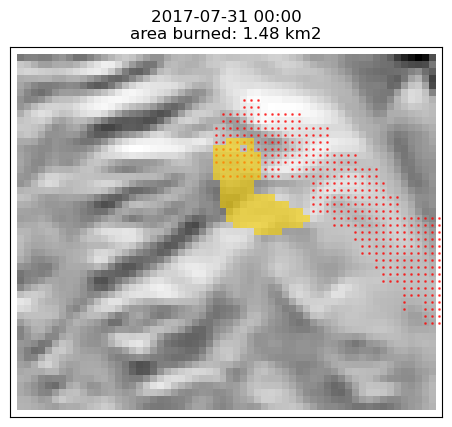

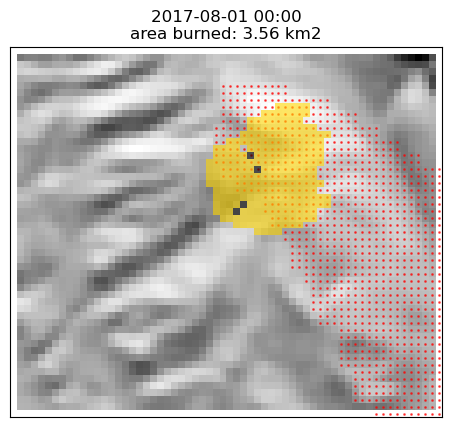

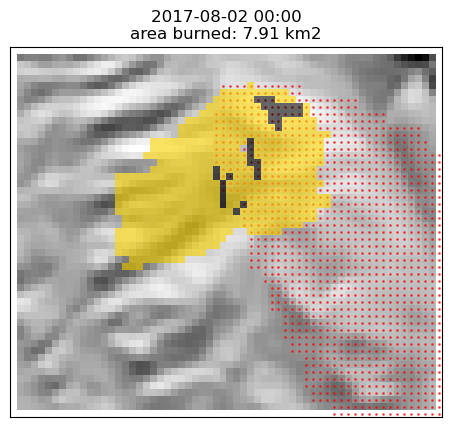

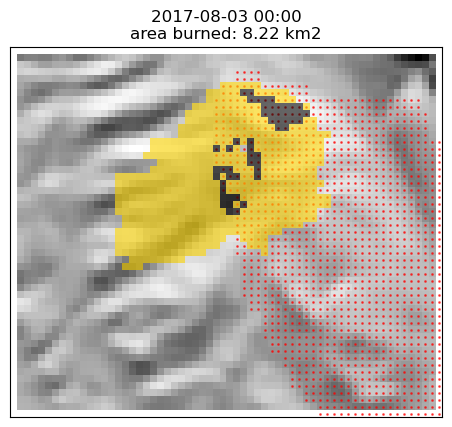

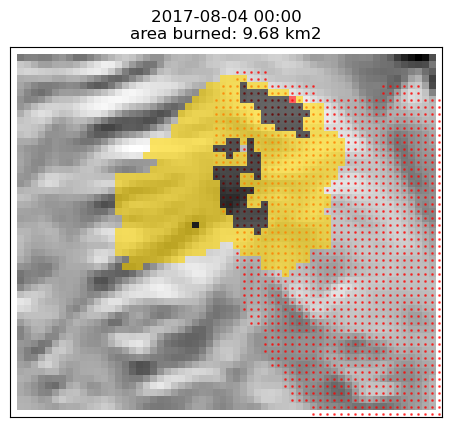

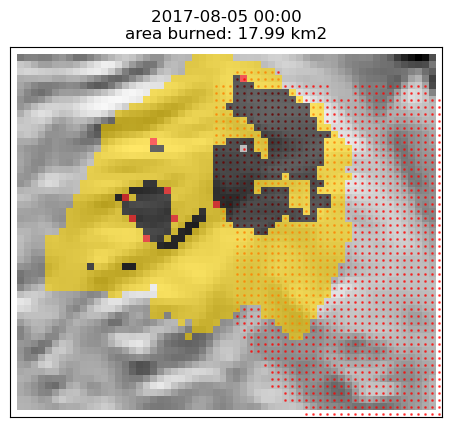

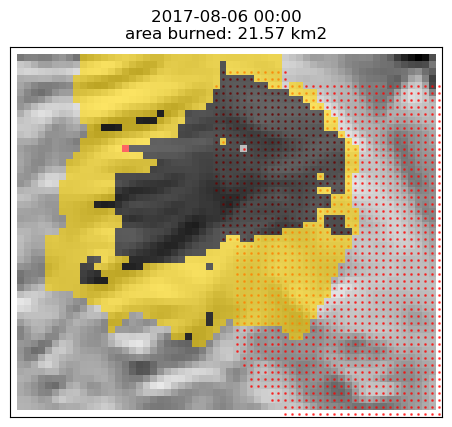

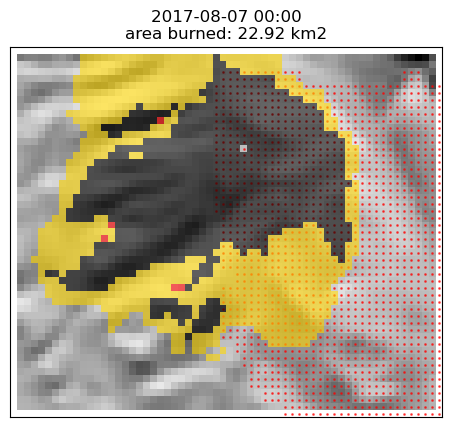

KeyboardInterrupt: 

In [51]:
CA.consts.update({'spatial_resolution':120,
                  's_base':2**2,
                  'weight':0.1,
                  'weight_d':0.8,
                  'weight_phi':0.7,
                  'spread_threshold':0.778,
                  'burn_speed':2.1/2**11,
                  'veg_dens_threshold':0.25,
                  'bare_dirt_threshold':0.1,
                  'ign_loc':set([tuple(x) for x in np.argwhere(CA.initial_state==2)]),
                  'start_time':np.datetime64('2017-07-24 00:00', 'h'),
                  'gif_dir':'/home/adam.viray/Documents/CA/output/GIF/'})
#CA.prob_cube = np.ones_like(CA.prob_cube)*0.7
CA.plotting = True
CA.show_plot = True
CA.reset()
#i,j = CA.consts['ign_loc']
#CA.burning.update(set([(y,x) for y in range(i-2,i+3) for x in range(j-2,j+3)]))
#CA.unburnable.update(set([(y,x) for y in range(110,115) for x in range(20,50)]))
#CA.unburnable.update(set([(y,x) for y in range(110,120) for x in range(50,60)]))
#CA.unburnable.update(set([(y,x) for y in range(115,125) for x in range(60,70)]))
#CA.unburnable.update(set([(y,x) for y in range(120,130) for x in range(70,80)]))
#CA.unburnable.update(set([(y,x) for y in range(125,135) for x in range(80,90)]))
#CA.unburnable.update(set([(y,x) for y in range(130,140) for x in range(90,100)]))
#CA.unburnable.update(set([(y,x) for y in range(135,145) for x in range(100,110)]))
#CA.unburnable.update(set([(y,x) for y in range(140,150) for x in range(110,120)]))
#CA.unburnable.update(set([(y,x) for y in range(145,155) for x in range(120,130)]))
#CA.unburnable.update(set([(y,x) for y in range(150,160) for x in range(130,140)]))
#CA.unburnable.update(set([(y,x) for y in range(155,165) for x in range(140,145)]))
CA.run()

In [309]:
fname = '/home/adam.viray/Documents/CA/prob_unc/RoS_base.csv'
np.savetxt(fname, CA.CA_burnt_pixels, delimiter=',')

## ChatGPT recommended this
to do get_adj_dw faster, vectorize

In [39]:
pixel = tuple((25,25))
i,j = pixel
r = 2.4
phi = 1
l = int(r)

weights = {}

candidate_coords_y, candidate_coords_x = np.meshgrid(
    np.arange(max(i - l, 0), min(i + l + 1, 50)),
    np.arange(max(j - l, 0), min(j + l + 1, 50))
)
candidate_coords = np.stack((candidate_coords_y.ravel(), candidate_coords_x.ravel()), axis=1)
candidate_coords = candidate_coords[np.all(candidate_coords != pixel, axis=1)]

theta = np.arctan2(i - candidate_coords[:, 0], candidate_coords[:, 1] - j)
diff = phi - theta
diff = np.where(diff > np.pi, 2*np.pi - diff, diff)
d = np.linalg.norm(np.array([i, j]) - candidate_coords, axis=1)

valid_neighbors = (
    (d <= np.sqrt(2) + r * np.exp(-np.sqrt(3) * np.abs(diff))) &
    (~np.isnan(CA.r_max[tuple(candidate_coords.T)]))
)

weight_values = (
    self.r_max[tuple(candidate_coords[valid_neighbors].T)] / 100 * self.consts['weight'] *
    np.exp((-(d[valid_neighbors] / ((r + 1) * self.consts['weight_d'])) ** 2 -
            (diff[valid_neighbors] / (np.pi / 2 * self.consts['weight_phi'])) ** 2) / 2)
)

for neighbor, weight in zip(valid_neighbor_coords, weight_values):
    weights[tuple(neighbor)] = weight

return weights

array([[24, 24],
       [26, 24],
       [23, 26],
       [24, 26],
       [26, 26],
       [23, 27],
       [24, 27]])

In [29]:
theta

array([ 2.35619449,  2.67794504, -2.67794504, -2.35619449,  2.03444394,
        2.35619449, -2.35619449, -2.03444394,  1.10714872,  0.78539816,
       -0.78539816, -1.10714872,  0.78539816,  0.46364761, -0.46364761,
       -0.78539816])

In [30]:
diff

array([1.35619449, 1.67794504, 3.67794504, 3.35619449, 1.03444394,
       1.35619449, 3.35619449, 3.03444394, 0.10714872, 0.21460184,
       1.78539816, 2.10714872, 0.21460184, 0.53635239, 1.46364761,
       1.78539816])

In [31]:
d

array([2.82842712, 2.23606798, 2.23606798, 2.82842712, 2.23606798,
       1.41421356, 1.41421356, 2.23606798, 2.23606798, 1.41421356,
       1.41421356, 2.23606798, 2.82842712, 2.23606798, 2.23606798,
       2.82842712])

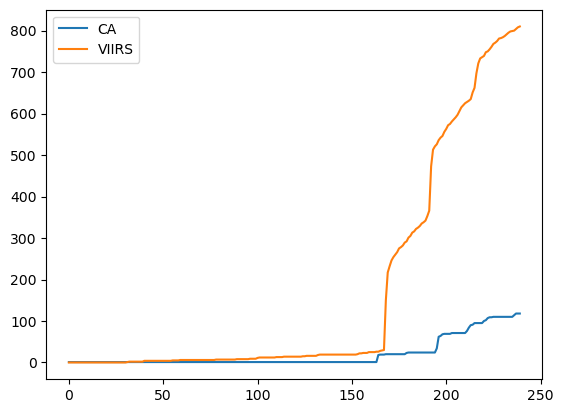

In [285]:
plt.plot(CA.CA_burnt_pixels[:240], label='CA')
plt.plot(CA.VIIRS_burnt_pixels[:240], label='VIIRS')
plt.legend()
plt.savefig('/home/adam.viray/Documents/CA/output/lines.png')
plt.show()

In [134]:
import os
import subprocess
file_list = []
ffconcat = ["ffconcat version 1.0\n"]
directory = '/home/adam.viray/Documents/CA/output/riceridge/120m/'
os.chdir(directory)
for root,dirs,files in os.walk(directory):
    for filename in files:
        if filename.endswith(".png"):
            file_list.append("file " + filename + "\n")
file_list.sort()
datetime_list = [np.datetime64(str(np.datetime64(int(fname[5:-5].split("_")[0]),'D'))+"T"+fname[5:-5].split("_")[1]) for fname in file_list]
duration_list = np.append(np.diff(datetime_list).astype('timedelta64[s]'), [3600]).astype(float)*32/3600/240
duration_list = [f"duration {duration:.3f}\n" for duration in duration_list]
ffconcat += [item for pair in zip(file_list, duration_list) for item in pair]
ffconcat += ffconcat[-2:]
fffilename = 'ffconcat.txt'
with open(fffilename, 'w') as f:
    f.writelines(ffconcat)
subprocess.run(f"ffmpeg -y -f concat -safe 0 -i {fffilename} -c:v libx264 -pix_fmt yuv420p -movflags +faststart output.mp4".split(" "))

In [ ]:
r_unc = nc.Dataset('/mnt/mordor3/data/VIIRS/raster_data/riceridge/fire_growth_meters_201706-201709_250m_stderr.nc')
RoS_unc_cube = r_unc['fire_growth'][53:]
del r_unc

wm = (CA.wspd*3.6)
wm = np.exp(0.05*wm)/(1+np.exp(0.6*(10-wm)))
# slope from Butler, Anderson, Catchpole 2007
sm = 0.001*np.exp(0.38*np.arctan(CA.slope/100)*180/np.pi) + 1.6

In [ ]:
CA.reset()
k = 433.02083338836576*(np.sqrt(2.6436051667022675 + 5.542458503024262e-05*(CA.RoS_cube-RoS_unc_cube)**2) - 1.6259167157952057)
CA.r_max_cube = np.sqrt(np.square(wm) + np.square(sm) + 2*wm*sm*np.cos(CA.wdir-CA.upslope))*np.repeat(k,24,axis=0)[:1344]
CA.r_max = CA.r_max_cube[0]
CA.run()
fname = '/home/adam.viray/Documents/CA/prob_unc/RoS_minus.csv'
np.savetxt(fname, CA.CA_burnt_pixels, delimiter=',')

In [ ]:
CA.reset()
k = 433.02083338836576*(np.sqrt(2.6436051667022675 + 5.542458503024262e-05*(CA.RoS_cube+RoS_unc_cube)**2) - 1.6259167157952057)
CA.r_max_cube = np.sqrt(np.square(wm) + np.square(sm) + 2*wm*sm*np.cos(CA.wdir-CA.upslope))*np.repeat(k,24,axis=0)[:1344]
CA.r_max = CA.r_max_cube[0]
CA.run()
fname = '/home/adam.viray/Documents/CA/prob_unc/RoS_plus.csv'
np.savetxt(fname, CA.CA_burnt_pixels, delimiter=',')

In [ ]:
import os
import pandas as pd

df = pd.DataFrame()
directory = '/home/adam.viray/Documents/CA/output/'
for root,dirs,files in os.walk(directory):
    for file in files:
        if file.endswith(".csv"):
            df[file[:-4]] = pd.read_csv(directory+file)

In [ ]:
for col in df.columns:
    plt.plot(df[col], label=col)
plt.plot(CA.VIIRS_burnt_pixels, label='VIIRS')
plt.legend()
plt.show()

In [ ]:
plt.plot(df['RoS_plus'][:10], label=f'plus, {np.mean(np.abs(df["RoS_plus"]-CA.VIIRS_burnt_pixels[:-1])): n}')
plt.plot(df['RoS_base'][:10], label=f'base, {np.mean(np.abs(df["RoS_base"]-CA.VIIRS_burnt_pixels[:-1])):n}')
plt.plot(df['RoS_minus'][:10], label=f'minus, {np.mean(np.abs(df["RoS_minus"]-CA.VIIRS_burnt_pixels[:-1])):n}')
plt.plot(CA.VIIRS_burnt_pixels, label='VIIRS')
plt.title(f"""
         veg_dens_threshold: {CA.consts['veg_dens_threshold']}, bare_dirt_threshold: {CA.consts['bare_dirt_threshold']},
         weight: {CA.consts['weight']}, weight_d: {CA.consts['weight_d']}, weight_phi: {CA.consts['weight_phi']},
         burn_speed:{CA.consts['burn_speed']}, spread_threshold: {CA.consts['spread_threshold']}""", y=1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(df['RoS_plus'], label=f'plus, {np.mean(np.abs(df["RoS_plus"]-CA.VIIRS_burnt_pixels[:-1])): n}')
plt.plot(df['RoS_base'], label=f'base, {np.mean(np.abs(df["RoS_base"]-CA.VIIRS_burnt_pixels[:-1])):n}')
plt.plot(df['RoS_minus'], label=f'minus, {np.mean(np.abs(df["RoS_minus"]-CA.VIIRS_burnt_pixels[:-1])):n}')
plt.plot(CA.VIIRS_burnt_pixels, label='VIIRS')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(df['base'], label='base')
plt.plot(df['notopo'], label='notopo')
plt.plot(df['RoS1'], label='RoS1')
plt.plot(df['RoS10'], label='RoS10')
plt.plot(df['RoS20'], label='RoS20')
plt.plot(df['RoS30'], label='RoS30')
plt.plot(df['RoS40'], label='RoS40')
plt.plot(df['RoS70'], label='RoS70')
plt.legend()
plt.show()

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(15,10), layout='tight')
for i in range(2):
    for j in range(3):
        ax[i,j].plot(df['base'], label='base')
        ax[i,j].plot(CA.VIIRS_burnt_pixels, label='VIIRS')
for label in df.columns:
    if 'notopo' in label:
        ax[0,0].plot(df[label], label=label)
    elif 'wspd' in label and 'wdir' not in label:
        ax[0,1].plot(df[label], label=label)
    elif 'wdir' in label and 'wspd' not in label:
        ax[0,2].plot(df[label], label=label)
    elif 'wdir' in label and 'wspd' in label:
        ax[1,0].plot(df[label], label=label)
    elif 'RoS' in label:
        ax[1,1].plot(df[label], label=label)
    elif 'prob' in label:
        ax[1,2].plot(df[label], label=label)
for i in range(2):
    for j in range(3):
        ax[i,j].legend()

plt.show()

In [ ]:
wm = (CA.wspd*3.6)
wm = np.exp(0.05*wm)/(1+np.exp(0.6*(6-wm)))
# slope from Butler, Anderson, Catchpole 2007
sm = 0.001*np.exp(0.38*np.arctan(CA.slope/100)*180/np.pi) + 1.6

In [ ]:
r_max_cube = np.sqrt(np.square(wm) + np.square(sm) + 2*wm*sm*np.cos(CA.wdir-CA.upslope))
phi_max_cube = (CA.upslope + np.arctan2(wm*np.sin(CA.wdir-CA.upslope), sm + wm*np.cos(CA.wdir-CA.upslope)))

In [ ]:
wx = np.multiply(wm, np.cos(CA.wdir))
wy = np.multiply(wm, np.sin(CA.wdir))
sx = np.multiply(sm, np.cos(CA.upslope))
sy = np.multiply(sm, np.sin(CA.upslope))
rx = np.multiply(r_max_cube, np.cos(phi_max_cube))
ry = np.multiply(r_max_cube, np.sin(phi_max_cube))

In [ ]:
plt.imshow(phi_max_cube[2], cmap=cmap, norm=norm)

In [ ]:
plt.imshow(CA.upslope, cmap=cmap, norm=norm)

In [ ]:
np.unique(wx)

In [ ]:
cmap = colors.ListedColormap(['red', 'yellow', 'green', 'blue','red'])
norm = colors.BoundaryNorm([-np.pi,-3*np.pi/4,-np.pi/4,np.pi/4,3*np.pi/4,np.pi], cmap.N)
for i in range(CA.t):
    fig,ax = plt.subplots(1,3,layout='tight',figsize=(20,5))
    ax[0].quiver(wx[i*24,::10,::10],wy[i*24,::10,::10], scale=50)
    ax[1].quiver(rx[i*24,::10,::10],ry[i*24,::10,::10], scale=50)
    ax[2].quiver(sx[::10,::10],sy[::10,::10], scale=50)
    plt.show()